In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models, transforms

from fastai.torch_core import requires_grad

In [2]:
# check if training using GPU is possible
torch.cuda.is_available()

True

In [3]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = "/content/gdrive/My Drive/Kaggle/NaturalPainters" # for original email
project_folder = "/content/gdrive/My Drive/NaturalPainters" 
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [5]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


# **Generator**

In [6]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

In [7]:
class Discriminator(nn.Module):
  def __init__(self, 
               img_channels: int, 
               num_features: int):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.conv2 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm2 = nn.BatchNorm2d(num_features)
    self.conv3 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm3 = nn.BatchNorm2d(num_features)
    self.conv4 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.norm4 = nn.BatchNorm2d(num_features*2)
    self.lin = nn.Linear(4*4*(num_features*2), 1)


  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), negative_slope = 0.2)
    x = F.leaky_relu(self.norm2(self.conv2(x)), negative_slope = 0.2)
    x = F.leaky_relu(self.norm3(self.conv3(x)), negative_slope = 0.2)
    x = F.leaky_relu(self.norm4(self.conv4(x)), negative_slope = 0.2)
    x = x.flatten(start_dim = 1)

    return self.lin(x)

In [8]:
# to check created model
# discriminator = Discriminator(hparams.img_channels, 
#                               hparams.img_height).cuda()
# discriminator

In [9]:
# to check on the output of the dataloader
# for num_iter, (stroke, condition) in enumerate(dataloader):  
#     condition = condition.cuda()
#     stroke = torch.stack([strokes_tfms(s) for s in stroke]).cuda()
#     break

# discriminator(stroke).shape

In [10]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
      super(Generator, self).__init__()

      self.out_features = img_height * img_width

      self.lin = nn.Linear(in_features, self.out_features)

      self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                      kernel_size = (4, 4), stride = (1, 1), bias = False)
      self.norm1 = nn.BatchNorm2d(num_features)

      self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm2 = nn.BatchNorm2d(num_features)

      self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm3 = nn.BatchNorm2d(num_features)

      self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm4 = nn.BatchNorm2d(num_features)

      self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                      kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
      self.norm5 = nn.BatchNorm2d(num_features)

      self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
      x = self.lin(x)
      x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
      x = self.norm1(x)
      x = F.relu(self.conv2(x), inplace = True)
      x = self.norm2(x)
      x = F.relu(self.conv3(x), inplace = True)
      x = self.norm3(x)
      x = F.relu(self.conv4(x), inplace = True)
      x = self.norm4(x)
      x = F.relu(self.conv5(x), inplace = True)
      x = self.norm5(x)

      return torch.tanh(self.conv6(x))

In [11]:
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div_(255))
                                  ])

In [14]:
#torch.manual_seed(4)
class Trainer():

        def __init__(self,
                     transforms,
                     generator: nn.Module,
                     discriminator: nn.Module,
                     optimizer: torch.optim,
                     loss: torch.nn.functional,
                     epochs: int = 3,
                     gpu: bool = False):
            super(Trainer, self).__init__()

            self.transforms = transforms
            self.generator = generator
            self.discriminator = discriminator
            self.optimizer = optimizer
            self.loss = loss
            self.epochs = epochs
            self.gpu = gpu

        def train(self,
              dataloader,
              print_interval: int = 50):
            
            train_loss = []
            
            for epoch in range(self.epochs):

                self.discriminator.train()

                for i, (stroke, action) in enumerate(dataloader):  

                    stroke = torch.stack([self.transforms(s) for s in stroke])
                    
                    y_true = torch.ones((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)
                    y_gen = torch.zeros((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)

                    if self.gpu:
                        action = action.cuda()
                        stroke = stroke.cuda()
                        y_true = y_true.cuda()
                        y_gen = y_gen.cuda()
                
                    self.optimizer.zero_grad()

                    y_true_pred = torch.sigmoid(self.discriminator(stroke))
                    true_loss = self.loss(y_true_pred, y_true)

                    gen_stroke = self.generator(action)
                    y_gen_pred = torch.sigmoid(self.discriminator(gen_stroke))
                    gen_loss = self.loss(y_gen_pred, y_gen)

                    cur_loss = 0.5 * true_loss + 0.5 * gen_loss
                    cur_loss.backward()

                    self.optimizer.step()

                    train_loss.append(cur_loss.data.item())

                    if (i % print_interval) == 0:
                        print('Epoch {}/{} | Sample {}/{} => Loss: {:.3f}'.format((epoch + 1), self.epochs,
                                                                          (i + 1), len(dataloader),
                                                                          torch.mean(torch.FloatTensor(train_loss))))
                        
                        s = stroke[0].clone().cpu()
                        print('true stroke')
                        print('discriminator prediction for true = 1:', round(y_true_pred[0].item(), 3))
                        display(to_pil_image(s))
            
                        g = gen_stroke[0].clone().cpu()
                        print('generated stroke')
                        print('discriminator prediction for true = 0:', round(y_gen_pred[0].item(), 3))
                        display(to_pil_image(g))
                        
                        print('-'*50)

                print('End of epoch {}'.format(epoch + 1))

            torch.save(self.discriminator.state_dict(), project_folder + '_discriminator_10e.pth')        

Training is performed using GPU.

Epoch 1/10 | Sample 1/196 => Loss: 0.705
true stroke
discriminator prediction for true = 1: 0.426756352186203


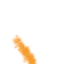

generated stroke
discriminator prediction for true = 0: 0.4176158308982849


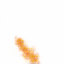

--------------------------------------------------
Epoch 1/10 | Sample 51/196 => Loss: 0.594
true stroke
discriminator prediction for true = 1: 0.640634298324585


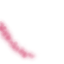

generated stroke
discriminator prediction for true = 0: 0.23237244784832


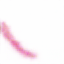

--------------------------------------------------
Epoch 1/10 | Sample 101/196 => Loss: 0.317
true stroke
discriminator prediction for true = 1: 0.9857856631278992


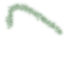

generated stroke
discriminator prediction for true = 0: 0.0016059551853686571


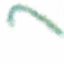

--------------------------------------------------
Epoch 1/10 | Sample 151/196 => Loss: 0.212
true stroke
discriminator prediction for true = 1: 0.9999158382415771


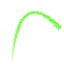

generated stroke
discriminator prediction for true = 0: 0.001885630888864398


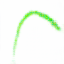

--------------------------------------------------
End of epoch 1
Epoch 2/10 | Sample 1/196 => Loss: 0.163
true stroke
discriminator prediction for true = 1: 0.9999126195907593


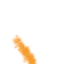

generated stroke
discriminator prediction for true = 0: 0.0006122391205281019


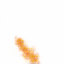

--------------------------------------------------
Epoch 2/10 | Sample 51/196 => Loss: 0.130
true stroke
discriminator prediction for true = 1: 0.999902606010437


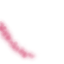

generated stroke
discriminator prediction for true = 0: 0.0003488590882625431


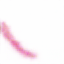

--------------------------------------------------
Epoch 2/10 | Sample 101/196 => Loss: 0.108
true stroke
discriminator prediction for true = 1: 0.9991074204444885


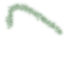

generated stroke
discriminator prediction for true = 0: 0.00012279536167625338


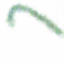

--------------------------------------------------
Epoch 2/10 | Sample 151/196 => Loss: 0.093
true stroke
discriminator prediction for true = 1: 0.9999756813049316


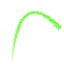

generated stroke
discriminator prediction for true = 0: 0.00021924756583757699


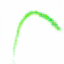

--------------------------------------------------
End of epoch 2
Epoch 3/10 | Sample 1/196 => Loss: 0.082
true stroke
discriminator prediction for true = 1: 0.9999756813049316


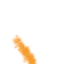

generated stroke
discriminator prediction for true = 0: 0.00016970436263363808


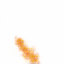

--------------------------------------------------
Epoch 3/10 | Sample 51/196 => Loss: 0.072
true stroke
discriminator prediction for true = 1: 0.9999665021896362


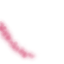

generated stroke
discriminator prediction for true = 0: 0.00010689469490898773


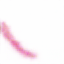

--------------------------------------------------
Epoch 3/10 | Sample 101/196 => Loss: 0.065
true stroke
discriminator prediction for true = 1: 0.9997032284736633


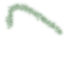

generated stroke
discriminator prediction for true = 0: 4.6981142077129334e-05


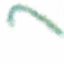

--------------------------------------------------
Epoch 3/10 | Sample 151/196 => Loss: 0.059
true stroke
discriminator prediction for true = 1: 0.999988317489624


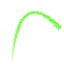

generated stroke
discriminator prediction for true = 0: 8.273436833405867e-05


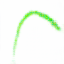

--------------------------------------------------
End of epoch 3
Epoch 4/10 | Sample 1/196 => Loss: 0.055
true stroke
discriminator prediction for true = 1: 0.9999885559082031


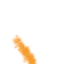

generated stroke
discriminator prediction for true = 0: 7.67970850574784e-05


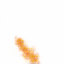

--------------------------------------------------
Epoch 4/10 | Sample 51/196 => Loss: 0.050
true stroke
discriminator prediction for true = 1: 0.9999829530715942


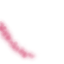

generated stroke
discriminator prediction for true = 0: 5.209862138144672e-05


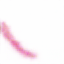

--------------------------------------------------
Epoch 4/10 | Sample 101/196 => Loss: 0.047
true stroke
discriminator prediction for true = 1: 0.9998582601547241


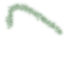

generated stroke
discriminator prediction for true = 0: 2.492231760697905e-05


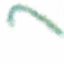

--------------------------------------------------
Epoch 4/10 | Sample 151/196 => Loss: 0.043
true stroke
discriminator prediction for true = 1: 0.9999932050704956


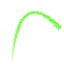

generated stroke
discriminator prediction for true = 0: 4.2980384023394436e-05


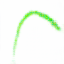

--------------------------------------------------
End of epoch 4
Epoch 5/10 | Sample 1/196 => Loss: 0.041
true stroke
discriminator prediction for true = 1: 0.9999934434890747


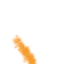

generated stroke
discriminator prediction for true = 0: 4.351081224740483e-05


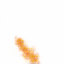

--------------------------------------------------
Epoch 5/10 | Sample 51/196 => Loss: 0.038
true stroke
discriminator prediction for true = 1: 0.9999897480010986


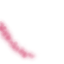

generated stroke
discriminator prediction for true = 0: 3.0945466278353706e-05


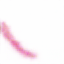

--------------------------------------------------
Epoch 5/10 | Sample 101/196 => Loss: 0.036
true stroke
discriminator prediction for true = 1: 0.999919056892395


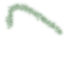

generated stroke
discriminator prediction for true = 0: 1.522294678579783e-05


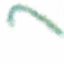

--------------------------------------------------
Epoch 5/10 | Sample 151/196 => Loss: 0.034
true stroke
discriminator prediction for true = 1: 0.9999954700469971


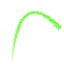

generated stroke
discriminator prediction for true = 0: 2.603112989163492e-05


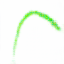

--------------------------------------------------
End of epoch 5
Epoch 6/10 | Sample 1/196 => Loss: 0.033
true stroke
discriminator prediction for true = 1: 0.9999958276748657


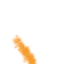

generated stroke
discriminator prediction for true = 0: 2.778880480036605e-05


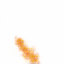

--------------------------------------------------
Epoch 6/10 | Sample 51/196 => Loss: 0.031
true stroke
discriminator prediction for true = 1: 0.9999933242797852


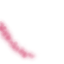

generated stroke
discriminator prediction for true = 0: 2.044828397629317e-05


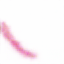

--------------------------------------------------
Epoch 6/10 | Sample 101/196 => Loss: 0.030
true stroke
discriminator prediction for true = 1: 0.9999493360519409


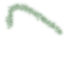

generated stroke
discriminator prediction for true = 0: 1.0207007107965183e-05


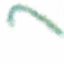

--------------------------------------------------
Epoch 6/10 | Sample 151/196 => Loss: 0.028
true stroke
discriminator prediction for true = 1: 0.9999967813491821


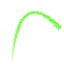

generated stroke
discriminator prediction for true = 0: 1.7080608813557774e-05


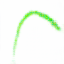

--------------------------------------------------
End of epoch 6
Epoch 7/10 | Sample 1/196 => Loss: 0.027
true stroke
discriminator prediction for true = 1: 0.9999971389770508


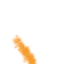

generated stroke
discriminator prediction for true = 0: 1.9087279724772088e-05


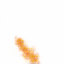

--------------------------------------------------
Epoch 7/10 | Sample 51/196 => Loss: 0.026
true stroke
discriminator prediction for true = 1: 0.9999953508377075


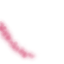

generated stroke
discriminator prediction for true = 0: 1.4444551197811961e-05


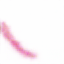

--------------------------------------------------
Epoch 7/10 | Sample 101/196 => Loss: 0.025
true stroke
discriminator prediction for true = 1: 0.9999661445617676


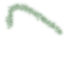

generated stroke
discriminator prediction for true = 0: 7.2428306339134e-06


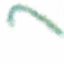

--------------------------------------------------
Epoch 7/10 | Sample 151/196 => Loss: 0.024
true stroke
discriminator prediction for true = 1: 0.9999974966049194


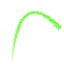

generated stroke
discriminator prediction for true = 0: 1.197948404296767e-05


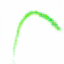

--------------------------------------------------
End of epoch 7
Epoch 8/10 | Sample 1/196 => Loss: 0.023
true stroke
discriminator prediction for true = 1: 0.9999979734420776


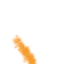

generated stroke
discriminator prediction for true = 0: 1.379089371766895e-05


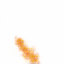

--------------------------------------------------
Epoch 8/10 | Sample 51/196 => Loss: 0.023
true stroke
discriminator prediction for true = 1: 0.999996542930603


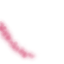

generated stroke
discriminator prediction for true = 0: 1.0687861504266039e-05


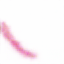

--------------------------------------------------
Epoch 8/10 | Sample 101/196 => Loss: 0.022
true stroke
discriminator prediction for true = 1: 0.9999761581420898


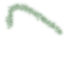

generated stroke
discriminator prediction for true = 0: 5.326215159584535e-06


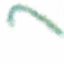

--------------------------------------------------
Epoch 8/10 | Sample 151/196 => Loss: 0.021
true stroke
discriminator prediction for true = 1: 0.9999980926513672


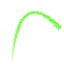

generated stroke
discriminator prediction for true = 0: 8.695181350049097e-06


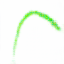

--------------------------------------------------
End of epoch 8
Epoch 9/10 | Sample 1/196 => Loss: 0.020
true stroke
discriminator prediction for true = 1: 0.9999984502792358


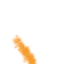

generated stroke
discriminator prediction for true = 0: 1.0336702871427406e-05


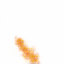

--------------------------------------------------
Epoch 9/10 | Sample 51/196 => Loss: 0.020
true stroke
discriminator prediction for true = 1: 0.9999973773956299


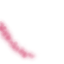

generated stroke
discriminator prediction for true = 0: 8.248207450378686e-06


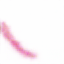

--------------------------------------------------
Epoch 9/10 | Sample 101/196 => Loss: 0.019
true stroke
discriminator prediction for true = 1: 0.9999825954437256


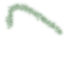

generated stroke
discriminator prediction for true = 0: 4.041452029923676e-06


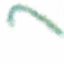

--------------------------------------------------
Epoch 9/10 | Sample 151/196 => Loss: 0.019
true stroke
discriminator prediction for true = 1: 0.9999984502792358


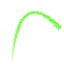

generated stroke
discriminator prediction for true = 0: 6.617053713853238e-06


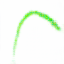

--------------------------------------------------
End of epoch 9
Epoch 10/10 | Sample 1/196 => Loss: 0.018
true stroke
discriminator prediction for true = 1: 0.9999988079071045


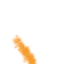

generated stroke
discriminator prediction for true = 0: 8.087355126917828e-06


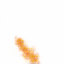

--------------------------------------------------
Epoch 10/10 | Sample 51/196 => Loss: 0.018
true stroke
discriminator prediction for true = 1: 0.9999979734420776


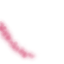

generated stroke
discriminator prediction for true = 0: 6.536477940244367e-06


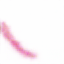

--------------------------------------------------
Epoch 10/10 | Sample 101/196 => Loss: 0.017
true stroke
discriminator prediction for true = 1: 0.9999868869781494


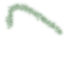

generated stroke
discriminator prediction for true = 0: 3.171273647240014e-06


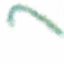

--------------------------------------------------
Epoch 10/10 | Sample 151/196 => Loss: 0.017
true stroke
discriminator prediction for true = 1: 0.9999988079071045


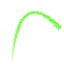

generated stroke
discriminator prediction for true = 0: 5.191632681089686e-06


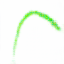

--------------------------------------------------
End of epoch 10


In [15]:
#torch.manual_seed(4)
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    batch_size = 512 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.001 #@param {type:"number"}
    betas = (0.5, 0.999) #@param
    epochs = 10 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 50 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

current_npz = 'episodes_1.npz'

strokes, actions = load_data(current_npz)

strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
actions = torch.stack([torch.from_numpy(action).float() for action in actions])

dataset = TensorDataset(strokes, actions)

dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

discriminator = Discriminator(hparams.img_channels, 
                              hparams.img_height)

gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

discriminator.to(device)

generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

generator_path = "/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters/results/generator_5152w_10e_1d.pth"

generator.load_state_dict(torch.load(generator_path, 
                                     map_location = torch.device(device)))

for param in generator.parameters():
    generator.requires_grad = False

generator.to(device).eval()

optimizer = optim.Adam(discriminator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

loss = F.binary_cross_entropy

trainer = Trainer(strokes_tfms,
                  generator,
                  discriminator,
                  optimizer,
                  loss,
                  epochs = hparams.epochs,
                  gpu = gpu)

trainer.train(dataloader, 
              print_interval = hparams.print_interval)